# Grover's Quantum Search Algorithm Tests

This Python notebook provides some practical tests and visualizations of the Grover Search algorithm. All tests have been executed on the **OpenQASM Simulator** (https://sooluthomas.github.io/testTranslation/terra/executing_quantum_programs.html#executing-quantum-programs) offered by Qiskit, but any other backend (simulator or real quantum machine) can be used to run these tests.

In [1]:
from qiskit import *
from qiskit.visualization import plot_histogram

from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

from random import getrandbits, randint

from binary_cost_function import *
from custom_gas import *
from num_base_converter import *

#### Cost function:

First we define a binary cost function. Our chosen function for testing will be:

$$
6 \cdot \left[\mathtt{X101}\right] + 3 \cdot \left[\mathtt{XXX0}\right] + 7 \cdot \left[\mathtt{X011}\right] - 2 \cdot \left[\mathtt{XXX1}\right] - 2 \cdot \left[\mathtt{01X1}\right],
$$

where $\mathtt{X}, \mathtt{0}$ and $\mathtt{1}$ denote free, 0 and 1 required bit values, respectively. That is, the cost function is:

$$
\mathcal{C}(x) = 6 \cdot x_2(1-x_3)x_4 + 3 \cdot (1-x_4) + 7 \cdot (1-x_2)x_3x_4 - 2 \cdot x_4 - 2 \cdot (1-x_1)x_2x_4.
$$

The clauses and values can be added, removed or changed as desired.

In [2]:
bcf_test = BinaryCostFunction(4)

clauses = [
    BinaryClause("X101"),
    BinaryClause("XXX0"),
    BinaryClause("X011"),
    BinaryClause("XXX1"),
    BinaryClause("01X1")
]

values = [6, 3, 7, -2, -2]

for clause, value in zip(clauses, values):
    bcf_test.add_clause(clause, value)
    
print(bcf_test)

6 * X101
3 * XXX0
7 * X011
-2 * XXX1
-2 * 01X1



#### Circuit parameters:

  - `n`: Number of qubits for the first regiter, which is the number of bits of the binary cost function.
  - `m`: Number of qubits for the second register, for storing the evaluated binary cost function.
  - `bcf`: Binary cost function to optimize.

Recall that the $m$ will allow us to store integer values on the interval $\left[-2^{m-1}, 2^{m-1}-1\right]$. With our cost function, the worst cases would be when only the positive (or negative) value clauses are satisfied, giving us upper and lower bounds of its image: $\left[-4, 16\right]$. For this reason, we will choose

$$
m = \lceil \log_{2}(\max(\lvert -4\rvert\ , \lvert 16 \rvert +1)) \rceil + 1 = \lceil \log_{2}(17) \rceil + 1 \approx \lceil 4.087463 \rceil + 1 = 6
$$

to allow for values in the range $\left[-32, 31\right]$. We now add an extra qubit to account for the threshold, so that there is no overflow/underflow when extreme values of the threshold are set, giving out a final value of $m = 7$.

Any other binary cost function with adequate $n, m$ parameters can be tested.

In [3]:
bcf = bcf_test
n = bcf.num_bits
m = math.ceil(math.log(max([sum(filter(lambda x: x>0, values)) + 1, -sum(filter(lambda x: x<0, values))]), 2)) + 2

print("n = ", n, ", m = ", m, sep = "")
print("bcf: ")
print(bcf)

n = 4, m = 7
bcf: 
6 * X101
3 * XXX0
7 * X011
-2 * XXX1
-2 * 01X1



#### Binary clause circuit implementation and tests:

Example circuit for the binary clause $\left[\mathtt{X010}\right]$ with value 6.

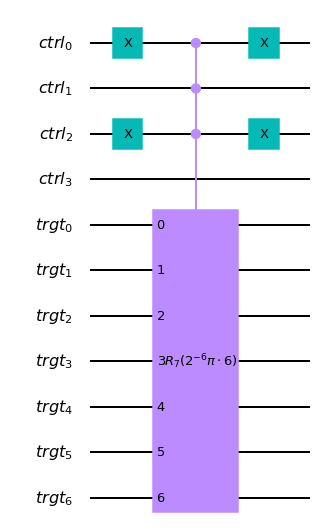

In [4]:
bc_circuit(m, BinaryClause("X010"), 6).draw(output = "mpl")

We test the gate by codifying the string $\left[\mathtt{0010}\right]$ on the `ctrl` register, which satisfies the clause. By adding other $X$ gates on other qubits of the `ctrl` register we can test other strings.

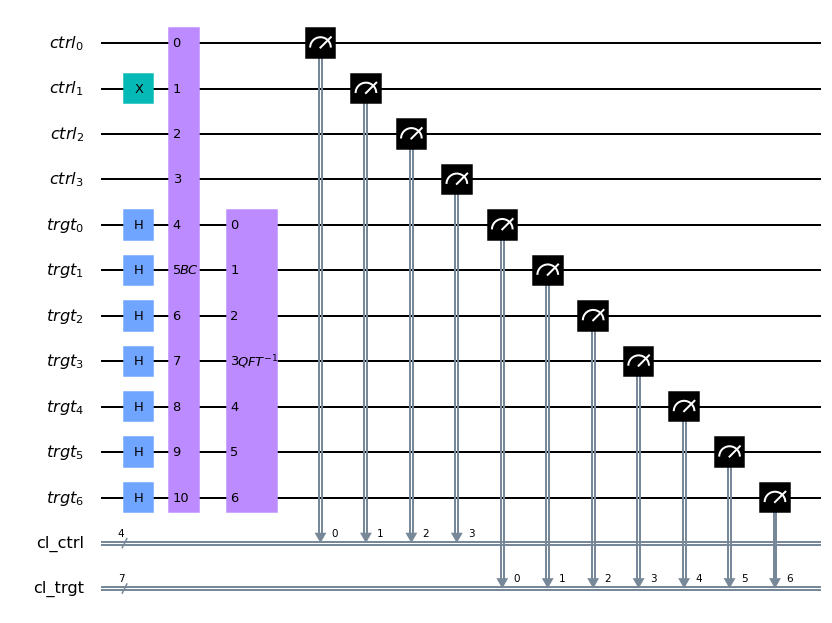

In [5]:
qc = QuantumCircuit()

qr_ctrl = QuantumRegister(n, "ctrl")
qr_trgt = QuantumRegister(m, "trgt")
cr_ctrl = ClassicalRegister(n, "cl_ctrl")
cr_trgt = ClassicalRegister(m, "cl_trgt")
qc.add_register(qr_ctrl)
qc.add_register(qr_trgt)
qc.add_register(cr_ctrl)
qc.add_register(cr_trgt)

qc.x(qr_ctrl[1])
qc.h(qr_trgt[:])

qc.append(bc_circuit(m, BinaryClause("X010"), 6).to_gate(label = "$BC$"), qr_ctrl[0:n] + qr_trgt[0:m])

qc.append(QFT_inv_circuit(m).to_gate(label = "$QFT^{-1}$"), qr_trgt[0:m])

qc.measure(qr_ctrl, cr_ctrl)
qc.measure(qr_trgt, cr_trgt)

qc.draw(output = "mpl")

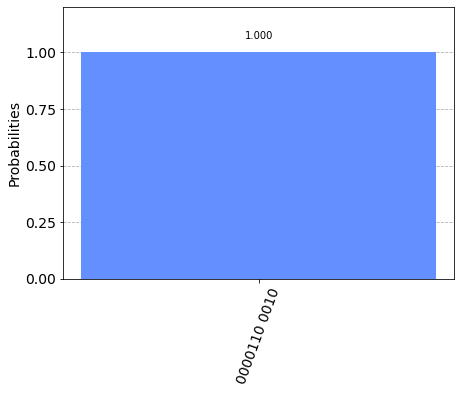

In [6]:
job = execute(qc, Aer.get_backend("qasm_simulator"), shots = 128)
counts = job.result().get_counts()
plot_histogram(counts)

Circuit for the binary cost function.

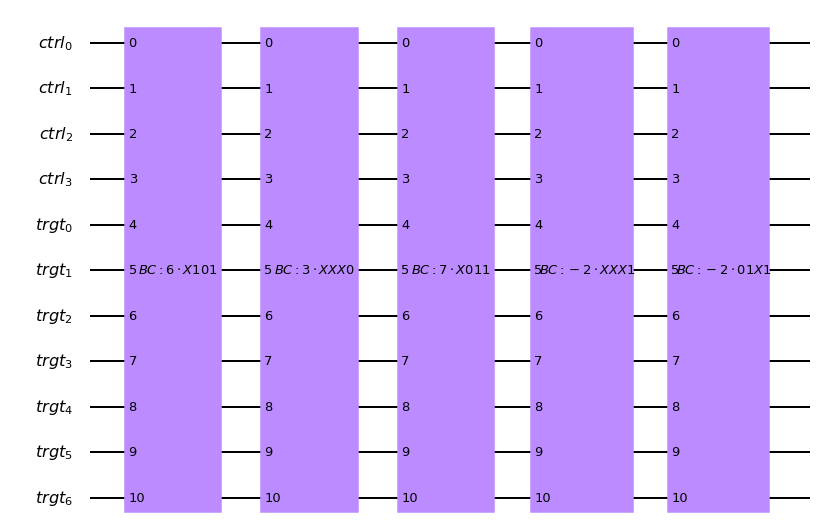

In [7]:
bcf_circuit(m, bcf).draw(output = "mpl")

We repeat the same test but now we evaluate the entire cost function on the string $\left[\mathtt{0010}\right]$. The expected value with this is string is:

In [8]:
bcf.evaluate("0010")

3

Any other string can be tested to check that the circuit works.

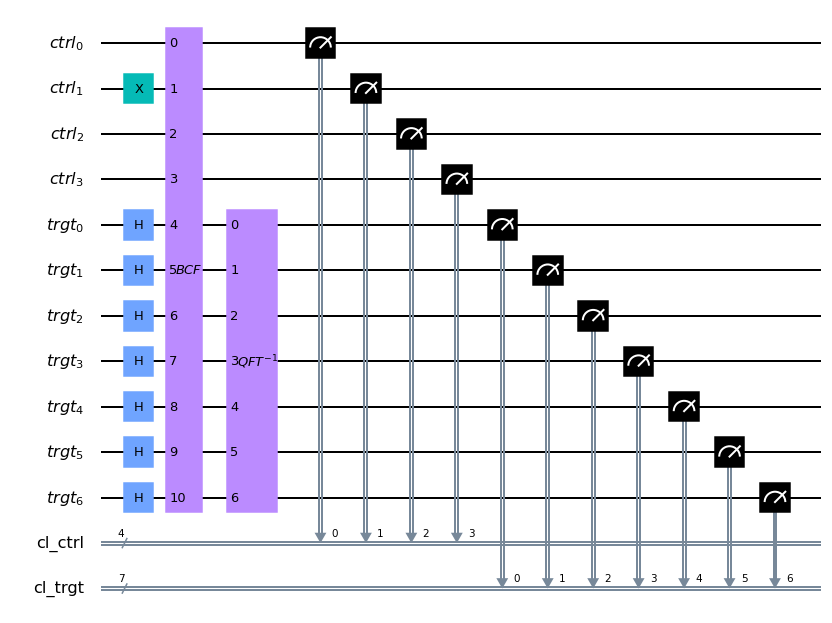

In [9]:
qc = QuantumCircuit()

qr_ctrl = QuantumRegister(n, "ctrl")
qr_trgt = QuantumRegister(m, "trgt")
cr_ctrl = ClassicalRegister(n, "cl_ctrl")
cr_trgt = ClassicalRegister(m, "cl_trgt")
qc.add_register(qr_ctrl)
qc.add_register(qr_trgt)
qc.add_register(cr_ctrl)
qc.add_register(cr_trgt)

qc.x(qr_ctrl[1])
qc.h(qr_trgt[:])

qc.append(bcf_circuit(m, bcf).to_gate(label = "$BCF$"), qr_ctrl[0:n] + qr_trgt[0:m])

qc.append(QFT_inv_circuit(m).to_gate(label = "$QFT^{-1}$"), qr_trgt[0:m])

qc.measure(qr_ctrl, cr_ctrl)
qc.measure(qr_trgt, cr_trgt)

qc.draw(output = "mpl")

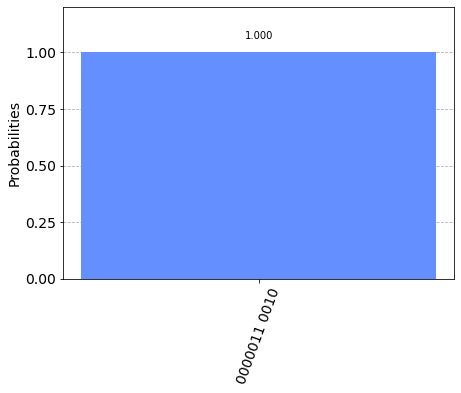

In [10]:
job = execute(qc, Aer.get_backend("qasm_simulator"), shots = 128)
counts = job.result().get_counts()
plot_histogram(counts)

#### Operator $A$, Iterator $G$ and final circuit:

State preparator and function evaluator $A$.

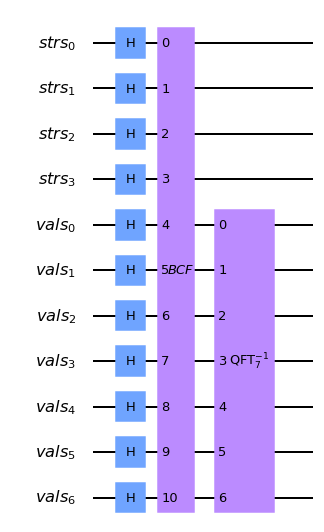

In [11]:
A_circuit(m, bcf).draw(output = "mpl")

Grover iterator $G = A D A^{-1} O$.

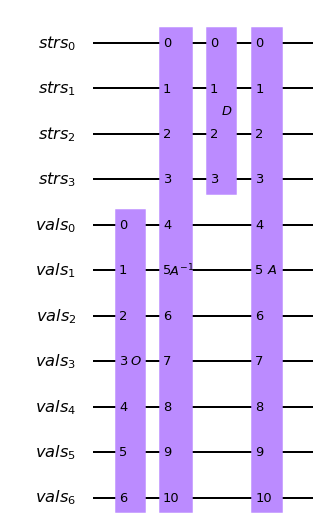

In [12]:
G_circuit(m, bcf).draw(output = "mpl")

The complete Grover Search circuit, which will be run iteratively with varying values of `threshold` and number of iteraitons `r`.

The `threshold` is implemented by adding an additional clause with bits $\left[\mathtt{X \dots X}\right]$ and value $-y$ where $y$ is the `threshold` for the current iteration.

This example shows the circuit with $y = 4$, $r = 3$.

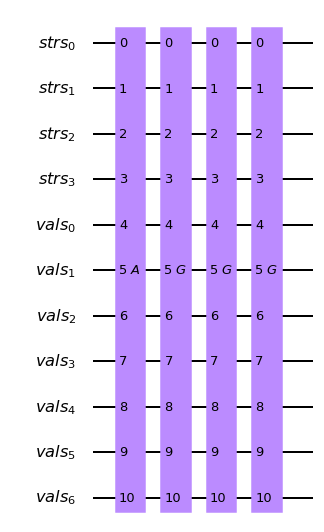

In [13]:
GAS_circuit(m, bcf, 4, 3).draw(output = "mpl")

#### Test run:

We now perform a test run of Grover Search with the following cost function:

$$
\mathcal{C}(x) = -1 \cdot \left[\mathtt{11111111}\right].
$$

In [14]:
bcf_test_2 = BinaryCostFunction(8)

clauses = [
    BinaryClause("1" * 8)
]

values = [-1]

for clause, value in zip(clauses, values):
    bcf_test_2.add_clause(clause, value)

We know the function has $2^{8} = 256$ possible options to try out, and only one of them will be optimal when `threshold = 0`, meaning the number of times the iterator $G$ must be applied is:

$$
r = \left \lfloor \frac{\pi}{4} \frac{1}{\arcsin{\left(\sqrt{\frac{1}{2^{8}}}\right)}} \right \rfloor = 12.
$$

In [15]:
bcf = bcf_test_2
n = bcf.num_bits
m = math.ceil(math.log(max([sum(filter(lambda x: x>0, values)) + 1, -sum(filter(lambda x: x<0, values))]), 2)) + 2
r = 12

print("n = ", n, ", m = ", m, ", r = ", r, sep = "")
print("bcf: ")
print(bcf)

n = 8, m = 2, r = 12
bcf: 
-1 * 11111111



Run the next cells to execute the test.

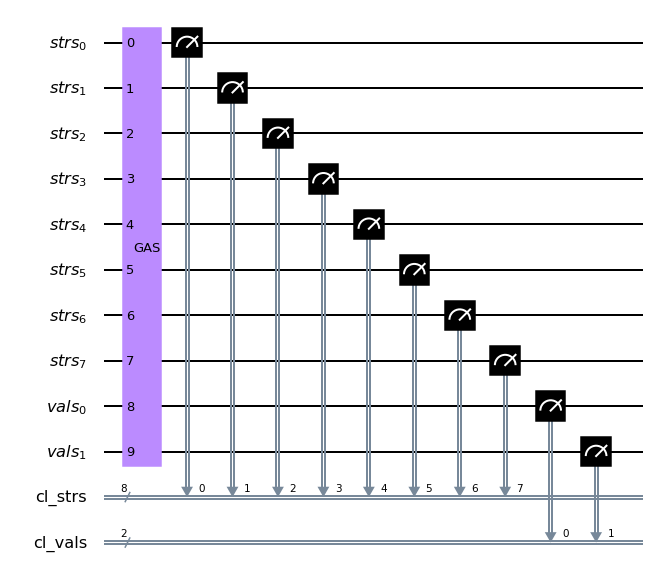

In [16]:
qc = QuantumCircuit()

qr_strs = QuantumRegister(n, "strs")
qr_vals = QuantumRegister(m, "vals")
cr_strs = ClassicalRegister(n, "cl_strs")
cr_vals = ClassicalRegister(m, "cl_vals")
qc.add_register(qr_strs)
qc.add_register(qr_vals)
qc.add_register(cr_strs)
qc.add_register(cr_vals)

GAS_gate = GAS_circuit(m, bcf, 0, r).to_gate(label = "GAS")
qc.append(GAS_gate, qr_strs[0:n] + qr_vals[0:m])

qc.measure(qr_strs, cr_strs)
qc.measure(qr_vals, cr_vals)

qc.draw(output = "mpl")

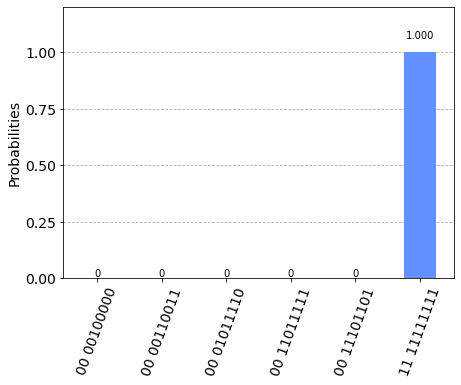

In [17]:
num_shots = 100000
job = execute(qc, Aer.get_backend("qasm_simulator"), shots = num_shots)
counts = job.result().get_counts()

plot_histogram(counts)

We can appreciate that the returned answer is almost surely the optimum string $\mathtt{11111111}$ and optimum value $-1$ with only $12$ applications of the iterator $G$. A classical computer would have to evaluate the cost function an average of $2^{n-1} = 128$ times to find the optimum string. Also, as $n$ grows, the probability of reading the correct answer also increases.

One will see that if we choose values of `r` other than the optimal value and then re-run the test, the probability of obtaining a better answer will decrease. Here we test $r \in [1, 30]$. We will run the tests on a $6$-bit clause instead of $8$ to lower execution time.

In [18]:
bcf_test_3 = BinaryCostFunction(6)

clauses = [
    BinaryClause("1" * 6)
]

values = [-1]

for clause, value in zip(clauses, values):
    bcf_test_3.add_clause(clause, value)

In [19]:
bcf = bcf_test_3
n = bcf.num_bits
m = math.ceil(math.log(max([sum(filter(lambda x: x>0, values)) + 1, -sum(filter(lambda x: x<0, values))]), 2)) + 2

print("n = ", n, ", m = ", m, ", r = ", r, sep = "")
print("bcf: ")
print(bcf)

n = 6, m = 2, r = 12
bcf: 
-1 * 111111



In [25]:
r_min = 1
r_max = 30
num_shots = 100000

r_vals = list(range(r_min, r_max+1))
percs = []
for r in r_vals:
    qc = QuantumCircuit()

    qr_strs = QuantumRegister(n, "strs")
    qr_vals = QuantumRegister(m, "vals")
    cr_strs = ClassicalRegister(n, "cl_strs")
    cr_vals = ClassicalRegister(m, "cl_vals")
    qc.add_register(qr_strs)
    qc.add_register(qr_vals)
    qc.add_register(cr_strs)
    qc.add_register(cr_vals)

    GAS_gate = GAS_circuit(m, bcf, 0, r).to_gate(label = "GAS")
    qc.append(GAS_gate, qr_strs[0:n] + qr_vals[0:m])

    qc.measure(qr_strs, cr_strs)
    qc.measure(qr_vals, cr_vals)

    qc.draw(output = "mpl")
    
    print("Running with r = {0:2d}... ".format(r), end = "")
    
    job = execute(qc, Aer.get_backend("qasm_simulator"), shots = num_shots)
    counts = job.result().get_counts()
    success_prob = counts.get("11 111111", 0)
    success_perc = 100*round(success_prob/num_shots, 4)
    percs.append(success_perc)
    
    print("Success probability: {0:2.2f}%".format(success_perc))

Running with r =  1... Success probability: 13.43%
Running with r =  2... Success probability: 34.53%
Running with r =  3... Success probability: 59.13%
Running with r =  4... Success probability: 81.62%
Running with r =  5... Success probability: 96.35%
Running with r =  6... Success probability: 99.65%
Running with r =  7... Success probability: 90.70%
Running with r =  8... Success probability: 71.78%
Running with r =  9... Success probability: 47.30%
Running with r = 10... Success probability: 23.76%
Running with r = 11... Success probability: 6.58%
Running with r = 12... Success probability: 0.00%
Running with r = 13... Success probability: 5.62%
Running with r = 14... Success probability: 22.47%
Running with r = 15... Success probability: 45.61%
Running with r = 16... Success probability: 70.13%
Running with r = 17... Success probability: 89.71%
Running with r = 18... Success probability: 99.41%
Running with r = 19... Success probability: 96.91%
Running with r = 20... Success pro

On the following graph we can appreciate the sinusoidal nature of the success probability of the algorithm.

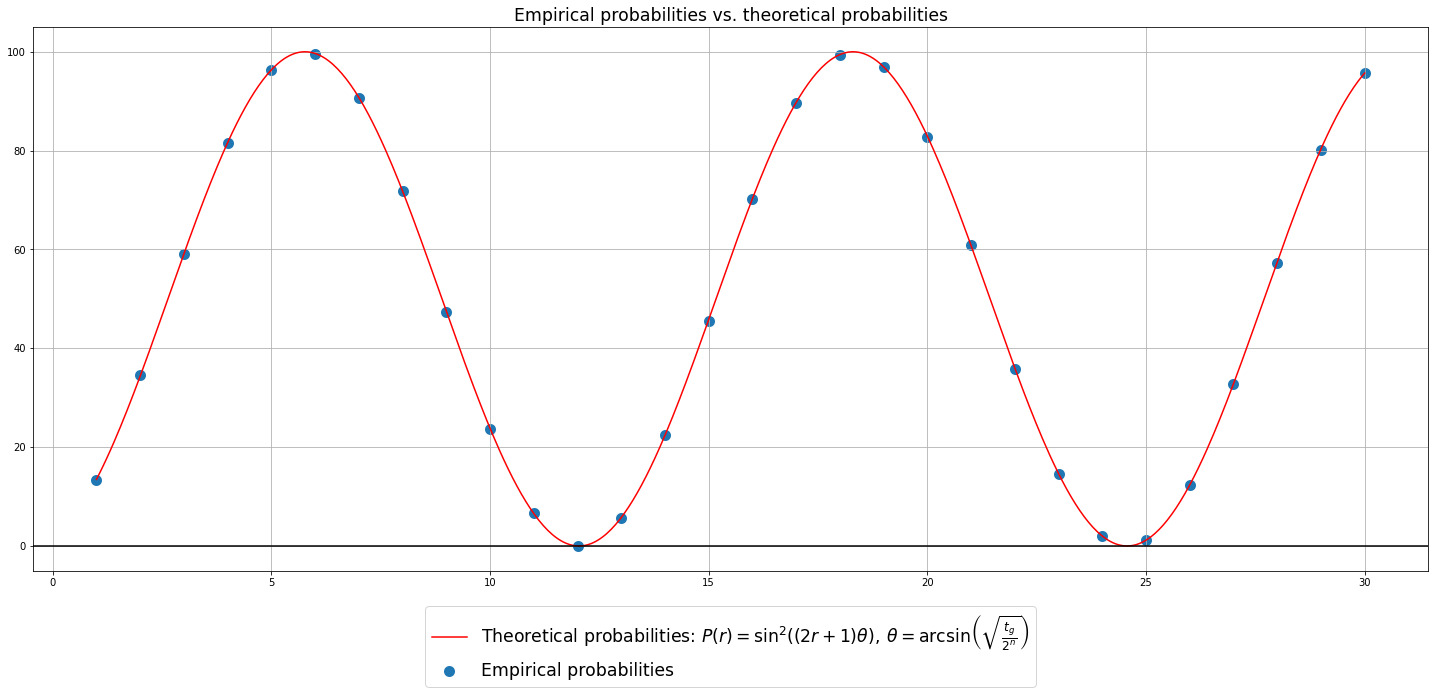

In [38]:
fig = plt.figure(figsize=(25,10))
ax = plt.subplot(1, 1, 1)
ax.scatter(r_vals, percs, linewidth = 5, label = "Empirical probabilities")
theta = math.asin(2**(-n/2))
x = np.linspace(r_min, r_max, (r_max - r_min) * 20)
ax.plot(x, 100*(np.sin(theta*((2*x)+1))**2), 'r', label = "Theoretical probabilities: " + r'$P(r) = \sin^2{((2r + 1)\theta)},\: \theta = \arcsin{\left(\sqrt{\frac{t_g}{2^n}}\right)}$')
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05), fontsize = "xx-large")
ax.set_title("Empirical probabilities vs. theoretical probabilities", fontsize = "xx-large")
ax.grid()
ax.axhline(color = "black")
plt.show()

The tests can be performed with any cost function that has any number of optimal and possible string values by choosing the adequate parameters. As $n$ grows, the times a classical function will have to evaluate the cost function grows in order $O(2^n)$, while the number of applications of the iterator $G$ grows in order $O(2^{\frac{n}{2}})$.